# TR-RB simulation

Luca Mechelli, Tim Keil

# Preparations

## details

In [1]:
import numpy as np

from matplotlib import pyplot as plt

from pymor.basic import *
set_log_levels({'pymor': 'WARN'})

In [2]:
from pymor.core.logger import set_log_levels, getLogger
set_log_levels({'pymor': 'ERROR',
                'distributed_adaptive_discretizations': 'DEBUG',
                'notebook': 'INFO'})
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12.0, 8.0)
mpl.rcParams['font.size'] = 12
mpl.rcParams['savefig.dpi'] = 300

## problem definition

In [3]:
from pymor.discretizers.builtin.cg import InterpolationOperator

grid, bi = load_gmsh('../../../fin_data/fin_mesh.msh')

from pdeopt.problems import Fin_problem

problem = Fin_problem(6)
mu_d = problem.parameter_space.sample_randomly(1, seed=222)[0] # 222
mu_d['biot'] = np.array(0.01)
# mu_for_u_d['k2'] = np.array(10)
mu_d['k0'] = np.array(0.1)
#mu_d['k3'] = np.array(0.1)
#mu_for_u_d['k4'] = np.array(0.1)
print('mu desired:', mu_d)

from pdeopt.discretizer import discretize_fin_pdeopt_stationary_cg

opt_fom, data, mu_bar = discretize_fin_pdeopt_stationary_cg(problem, grid, bi, mu_d, 
                                                            product='fixed_energy',
                                                            add_constant_term=True)

mu desired: {biot: 0.01, k0: 0.1, k1: 8.37317446377103, k2: 6.572276066240383, k3: 0.46651735398635275, k4: 1.8835410659596712}
I am using the corrected functional!!
I am using the OLD gradient!!
{biot: 0.1, k0: 1.0, k1: 1.0, k2: 1.0, k3: 1.0, k4: 1.0}
my product is fixed_energy


In [4]:
print('information on the grid:')
print(data['grid'])

radius = 0.1               # TR radius 
FOC_tolerance = 5e-4       # tau_FOC
sub_tolerance = 1e-8       # tau_sub
safety_tol = 1e-16         # Safeguard, to avoid running the optimizer for really small difference in digits
max_it = 40                # Maximum number of iteration for the TR algorithm
max_it_sub = 400           # Maximum number of iteration for the TR optimization subproblem
max_it_arm = 50            # Maximum number of iteration for the Armijo rule
init_step_armijo = 0.5     # Initial step for the Armijo rule
armijo_alpha = 1e-4        # kappa_arm
beta = 0.95                # beta_2
epsilon_i = 1e-8           # Treshold for the epsilon active set (Kelley '99)

information on the grid:
UnstructuredTriangleGrid with 151072 triangles, 228608 edges, 77537 vertices


Now we pick one specific starting parameter

In [5]:
# starting with
mu = problem.parameter_space.sample_randomly(1, seed= 758)[0]
print(mu)

{biot: 0.31443290532552476, k0: 5.2380093294844015, k1: 4.453612643567742, k2: 4.351199118159355, k3: 2.96650091816554, k4: 8.196789068750364}


## Visualizations

Visualize the position of left- and right-hand sides parameters

<pymor.discretizers.builtin.gui.jupyter.patch.visualize_patch.<locals>.Plot at 0x7f28e34e9d10>

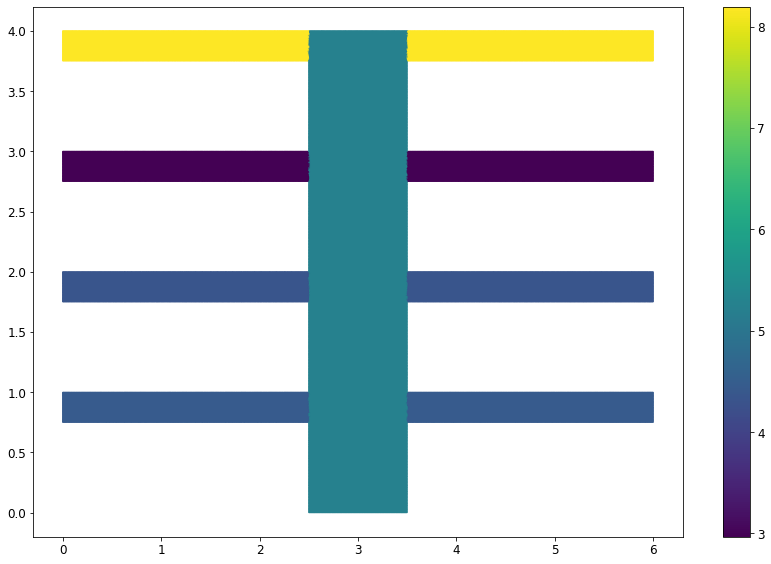

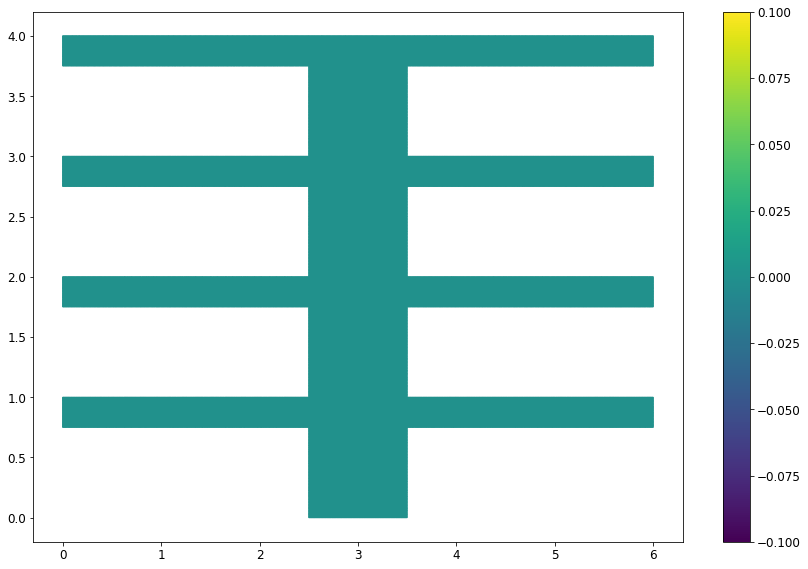

In [6]:
from pymor.discretizers.builtin.cg import InterpolationOperator

vis_mu = mu
diff = InterpolationOperator(data['grid'], problem.diffusion).as_vector(vis_mu)
rhs = InterpolationOperator(data['grid'], problem.rhs).as_vector(vis_mu)
opt_fom.visualize(diff)
opt_fom.visualize(rhs)

We can easily solve the primal and dual equations by calling 

<pymor.discretizers.builtin.gui.jupyter.patch.visualize_patch.<locals>.Plot at 0x7f28e41c8c10>

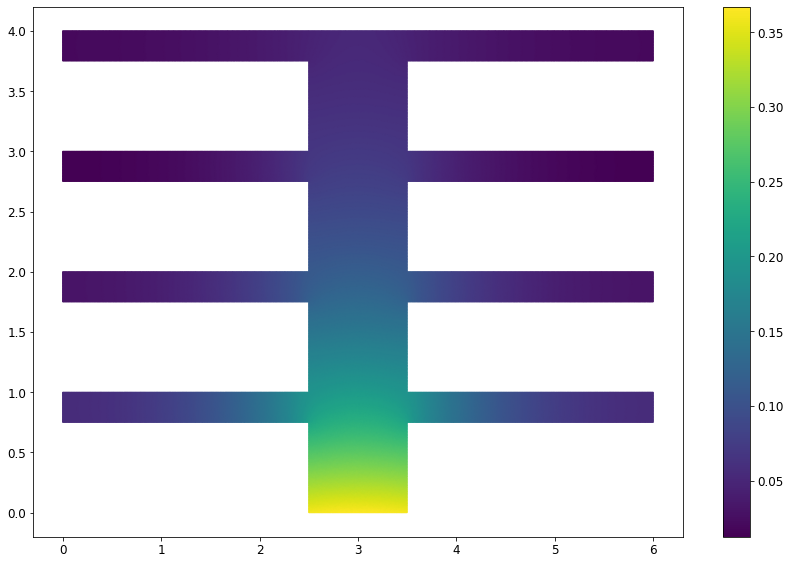

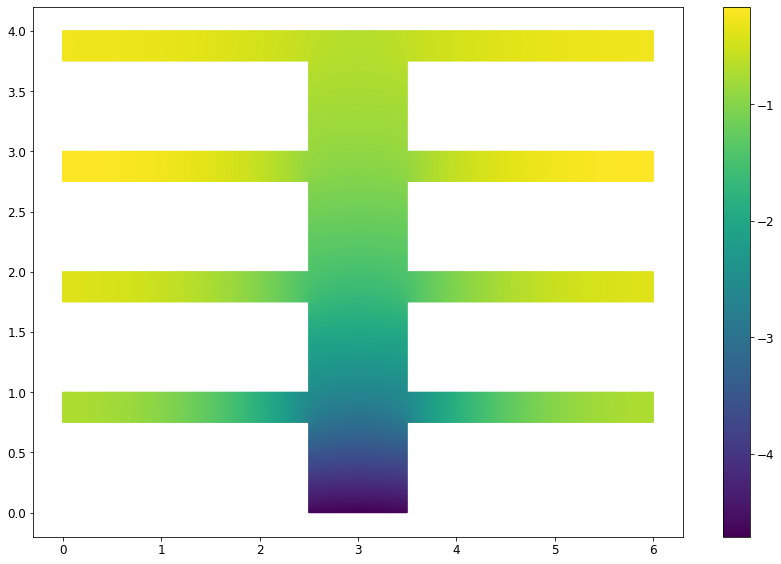

In [7]:
u = opt_fom.solve(mu)
p = opt_fom.solve_dual(mu)

opt_fom.visualize(u)
opt_fom.visualize(p)

# Full Order Optimization

In [8]:
mu_opt = mu_d

mu_opt_as_array = opt_fom.parse_parameter_inverse(mu_opt)
J_opt = opt_fom.output_functional_hat(mu_opt)
print('Optimal parameter: ', mu_opt_as_array)
print('Optimal J: ', J_opt)

print()
print('Starting parameter: ', opt_fom.parse_parameter_inverse(mu))
J_start = opt_fom.output_functional_hat(mu)
print('Starting J: ', J_start)

Optimal parameter:  [0.01       0.1        8.37317446 6.57227607 0.46651735 1.88354107]
Optimal J:  1.0

Starting parameter:  [0.31443291 5.23800933 4.45361264 4.35119912 2.96650092 8.19678907]
Starting J:  1887.0276550243555


## FOM BFGS

In [9]:
from pdeopt.TR import solve_optimization_subproblem_BFGS
from pdeopt.tools import compute_errors, compute_actual_errors

TR_parameters = {'radius': 1.e18, 'sub_tolerance': FOC_tolerance, 
                 'max_iterations_subproblem': max_it_sub,
                 'starting_parameter': mu, 
                 'epsilon_i': epsilon_i,
                 'max_iterations_armijo': max_it_arm, 'initial_step_armijo': init_step_armijo,
                 'armijo_alpha': armijo_alpha,
                 'full_order_model': True }


muoptfom,_,_,_, times_2, mus_2, Js_2, FOC_2 = solve_optimization_subproblem_BFGS(opt_fom,opt_fom.parameter_space,mu,TR_parameters, timing=True)
times_full_2, J_error_2, mu_error_2 = compute_errors(opt_fom, J_start, J_opt, mu, mu_opt_as_array, 
                                               mus_2, Js_2, times_2, 0)

Starting parameter {biot: 0.31443290532552476, k0: 5.2380093294844015, k1: 4.453612643567742, k2: 4.351199118159355, k3: 2.96650091816554, k4: 8.196789068750364}
Step [0.01       0.1        4.425199   4.37525512 0.1        6.41488334], functional 4.3726589892350205 , FOC condition 7.46667127080159
Step [0.01025904 0.10005408 4.42519909 4.37525582 0.10001298 6.41485096], functional 4.37031197455228 , FOC condition 2.109563548342993
Step [0.01008084 0.10094359 4.42520756 4.37525459 0.10062267 6.41509236], functional 4.369493537503772 , FOC condition 2.1064099597932637
Step [0.01105534 0.1        4.44595246 4.39241706 0.7848098  6.02178317], functional 3.8839422521310496 , FOC condition 1.3543779674967753
Step [0.01       0.1        4.51549008 4.46550751 0.37597709 4.09150372], functional 1.8647593185876303 , FOC condition 4.792025408007006
Step [0.01016663 0.10003531 4.515491   4.46550839 0.37597721 4.09148803], functional 1.8637562069497733 , FOC condition 0.7516977110563516
Step [0.01 

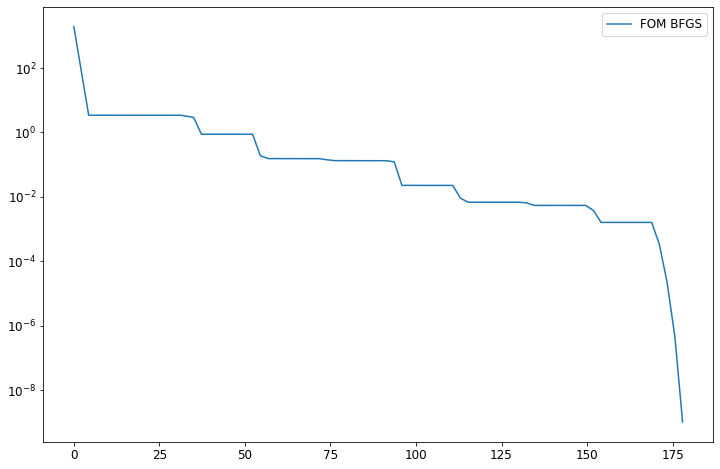

In [10]:
plt.semilogy(times_full_2,J_error_2, label='FOM BFGS')
plt.legend()

# TR approach

In [11]:
from pdeopt.model import build_initial_basis
from pdeopt.reductor import QuadraticPdeoptStationaryCoerciveReductor

from pymor.parameters.functionals import MinThetaParameterFunctional

ce = MinThetaParameterFunctional(opt_fom.primal_model.operator.coefficients, mu_bar)

## BFGS (Lagrange-Basis)

#### NCD-Corrected Functional - Variant 3(a)

In [12]:
import time
tic = time.time()
params = [mu]
opt_fom = opt_fom.with_(use_corrected_functional=True)
opt_fom = opt_fom.with_(use_corrected_gradient=False)
opt_fom = opt_fom.with_(adjoint_approach=True)


RBbasis, dual_RBbasis = build_initial_basis(opt_fom, params, build_sensitivities=False)

pdeopt_reductor = QuadraticPdeoptStationaryCoerciveReductor(opt_fom, 
                                                            RBbasis, dual_RBbasis, 
                                                            opt_product=opt_fom.opt_product,
                                                            coercivity_estimator=ce,
                                                            mu_bar=mu_bar,
                                                            adjoint_estimate=True)

opt_rom = pdeopt_reductor.reduce()

tictoc = time.time() - tic

TR_parameters = {'beta': beta,
                 'safety_tolerance': safety_tol,
                 'radius': radius, 'FOC_tolerance': FOC_tolerance, 
                 'sub_tolerance': sub_tolerance,
                 'max_iterations': max_it, 'max_iterations_subproblem': max_it_sub, 
                 'max_iterations_armijo': max_it_arm,
                 'initial_step_armijo': init_step_armijo, 
                 'armijo_alpha': armijo_alpha, 
                 'epsilon_i': epsilon_i, 
                 'starting_parameter': mu, 
                 'opt_method': 'BFGSMethod'}

extension_params = {"Enlarge_radius": True, 'timings': True}

from pdeopt.TR import TR_algorithm

mus_23, times_23, Js_23, FOC_23 = TR_algorithm(opt_rom, pdeopt_reductor, TR_parameters, extension_params)

times_full_23_actual, J_error_23_actual, mu_error_23_actual, FOC_23_actual = compute_errors(
    opt_fom, J_start, J_opt, mu, mu_opt_as_array, mus_23[1:], Js_23, times_23, tictoc, FOC_23)

Starting with two bases. Primal and dual have length 1 and 1
starting parameter {biot: 0.31443290532552476, k0: 5.2380093294844015, k1: 4.453612643567742, k2: 4.351199118159355, k3: 2.96650091816554, k4: 8.196789068750364}
Starting value of the cost: 1887.0276550243552
******************************* 

___ starting subproblem
Computing the approximate Cauchy point and then start the BFGS method
boundary criterium of the TR satisfied, so stopping the sub-problem solver
checked sufficient condition, starting the enrichment
Enrichment completed... length of Bases are 2, 2, [] and []
k: 0 - j 6 - Cost Functional: 139.06794514248128 - mu: {biot: 0.09498974371512442, k0: 0.791513353273576, k1: 3.9222267508164648, k2: 4.195958045942587, k3: 1.4811220074249578, k4: 7.415558500172395}
computing the fom gradient since the model was enriched
First order critical condition: 2.203457865295548
******************************* 

___ starting subproblem
Computing the approximate Cauchy point and then s

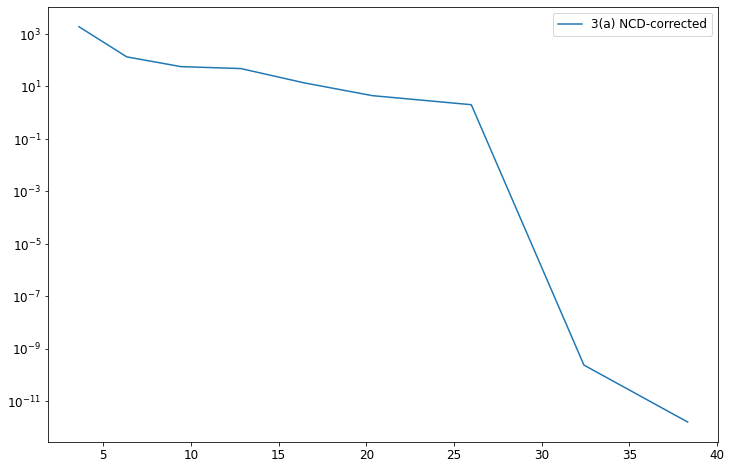

In [13]:
plt.semilogy(times_full_23_actual,J_error_23_actual, label='3(a) NCD-corrected')
plt.legend()

#### Standard approach - Variant 1(a)

In [14]:
import time
tic = time.time()
params = [mu]
opt_fom = opt_fom.with_(use_corrected_functional=False)
opt_fom = opt_fom.with_(use_corrected_gradient=False)
opt_fom = opt_fom.with_(adjoint_approach=False)


RBbasis, dual_RBbasis = build_initial_basis(opt_fom, params, build_sensitivities=False)

pdeopt_reductor = QuadraticPdeoptStationaryCoerciveReductor(opt_fom, 
                                                            RBbasis, dual_RBbasis, 
                                                            opt_product=opt_fom.opt_product,
                                                            coercivity_estimator=ce,
                                                            mu_bar=mu_bar)

opt_rom = pdeopt_reductor.reduce()

tictoc = time.time() - tic

TR_parameters = { 'beta': beta,
                 'safety_tolerance': safety_tol,
                 'radius': radius, 'FOC_tolerance': FOC_tolerance, 
                 'sub_tolerance': sub_tolerance,
                 'max_iterations': max_it, 'max_iterations_subproblem': max_it_sub, 
                 'max_iterations_armijo': max_it_arm,
                 'initial_step_armijo': init_step_armijo, 
                 'armijo_alpha': armijo_alpha, 
                 'epsilon_i': epsilon_i, 
                 'starting_parameter': mu, 
                 'opt_method': 'BFGSMethod'}

extension_params = {"Enlarge_radius": True, 'timings': True}
from pdeopt.TR import TR_algorithm
mus_25, times_25, Js_25, FOC_25 = TR_algorithm(
    opt_rom, pdeopt_reductor, TR_parameters, extension_params)

times_full_25_actual, J_error_25_actual, mu_error_25_actual, FOC_25_actual = compute_errors(
    opt_fom, J_start, J_opt, mu, mu_opt_as_array, mus_25[1:], Js_25, times_25, tictoc, FOC_25)


Starting with two bases. Primal and dual have length 1 and 1
starting parameter {biot: 0.31443290532552476, k0: 5.2380093294844015, k1: 4.453612643567742, k2: 4.351199118159355, k3: 2.96650091816554, k4: 8.196789068750364}
Starting value of the cost: 1887.027655024356
******************************* 

___ starting subproblem
Computing the approximate Cauchy point and then start the BFGS method
boundary criterium of the TR satisfied, so stopping the sub-problem solver
checked sufficient condition, starting the enrichment
Enrichment completed... length of Bases are 2, 2, [] and []
k: 0 - j 6 - Cost Functional: 139.06794514248347 - mu: {biot: 0.09498974371512463, k0: 0.7915133532735866, k1: 3.922226750816509, k2: 4.195958045942601, k3: 1.4811220074249538, k4: 7.415558500172397}
computing the fom gradient since the model was enriched
First order critical condition: 2.2034578652955568
******************************* 

___ starting subproblem
Computing the approximate Cauchy point and then s

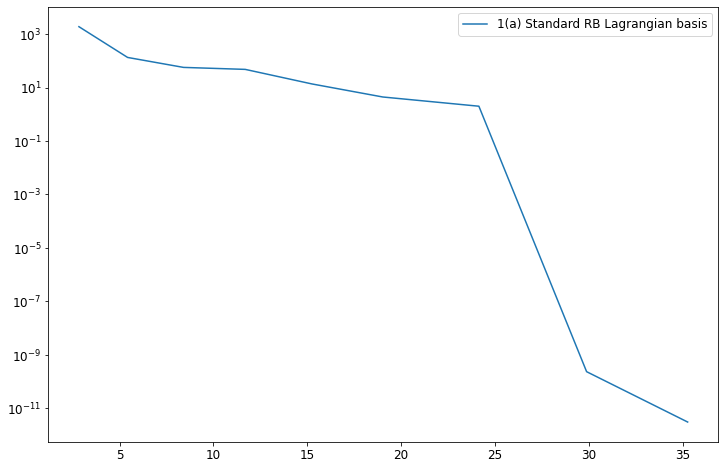

In [15]:
plt.semilogy(times_full_25_actual,J_error_25_actual, label='1(a) Standard RB Lagrangian basis')
plt.legend()

#### Qian et al. 2017 version

In [16]:
#Qian-Grepl
opt_fom = opt_fom.with_(use_corrected_functional=False)
opt_fom = opt_fom.with_(use_corrected_gradient=False)
opt_fom = opt_fom.with_(adjoint_approach=False)
tic = time.time()
params = [mu]


RBbasis, dual_RBbasis = build_initial_basis(opt_fom, params)

pdeopt_reductor = QuadraticPdeoptStationaryCoerciveReductor(opt_fom, 
                                                            RBbasis, dual_RBbasis, 
                                                            opt_product=opt_fom.opt_product, 
                                                            coercivity_estimator=ce, mu_bar=mu_bar,
                                                            prepare_for_gradient_estimate= True)

opt_rom = pdeopt_reductor.reduce()
tictoc = time.time() - tic

TR_parameters = {'Qian-Grepl': True,
                 'beta': beta, 'safety_tolerance': safety_tol,
                 'radius': radius, 'FOC_tolerance': FOC_tolerance, 
                 'sub_tolerance': sub_tolerance,
                 'max_iterations': max_it, 'max_iterations_subproblem': max_it_sub, 
                 'max_iterations_armijo': max_it_arm,
                 'initial_step_armijo': init_step_armijo, 
                 'armijo_alpha': armijo_alpha, 
                 'epsilon_i': epsilon_i,  
                 'starting_parameter': mu, 
                 'opt_method': 'BFGSMethod'}

extension_params = {"Enlarge_radius": False, 'timings': True}

mus_26, times_26,Js_26, FOC_26, opt_rom = TR_algorithm(
    opt_rom, pdeopt_reductor, TR_parameters, extension_params, return_opt_rom=True)

times_full_26_actual, J_error_26_actual, FOC_26_actual, mu_error_26_actual = compute_actual_errors(
    opt_fom, J_start, J_opt, mus_26, times_26, tictoc, mu, mu_opt_as_array)

Starting with two bases. Primal and dual have length 1 and 1
GRAD J ESTIMATOR: non corrected estimator
QIAN et al. 2017 Method
starting parameter {biot: 0.31443290532552476, k0: 5.2380093294844015, k1: 4.453612643567742, k2: 4.351199118159355, k3: 2.96650091816554, k4: 8.196789068750364}
Starting value of the cost: 1887.027655024356
******************************* 

___ starting subproblem
Computing the approximate Cauchy point and then start the BFGS method
boundary criterium of the TR satisfied, so stopping the sub-problem solver
checked sufficient condition, starting the enrichment
Enrichment completed... length of Bases are 2, 2, [] and []
GRAD J ESTIMATOR: non corrected estimator
k: 0 - j 6 - Cost Functional: 139.06794514248347 - mu: {biot: 0.09498974371512463, k0: 0.7915133532735866, k1: 3.922226750816509, k2: 4.195958045942601, k3: 1.4811220074249538, k4: 7.415558500172397}
estimate_gradient 1.1019546705601462e-10
First order critical condition: 2.20345786529555
****************

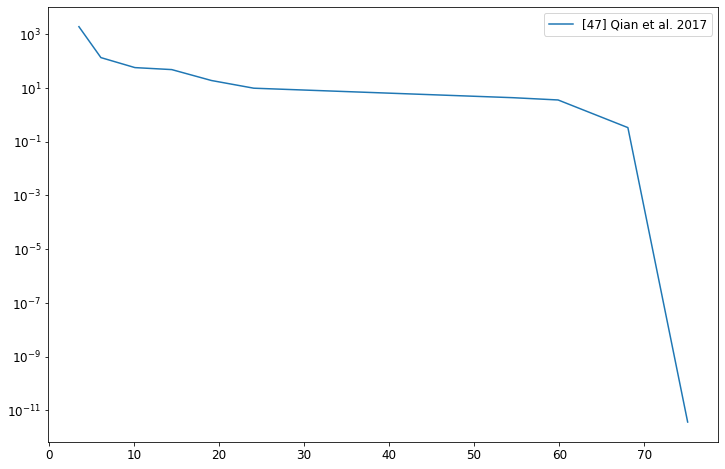

In [17]:
plt.semilogy(times_full_26_actual,J_error_26_actual, label='[47] Qian et al. 2017')
plt.legend()

#### semi NCD-corrected (Variant 2a)

In [18]:
import time
tic = time.time()
params = [mu]
opt_fom = opt_fom.with_(use_corrected_functional=True)
opt_fom = opt_fom.with_(use_corrected_gradient=False)
opt_fom = opt_fom.with_(adjoint_approach=False)


RBbasis, dual_RBbasis = build_initial_basis(opt_fom, params, build_sensitivities=False)

pdeopt_reductor = QuadraticPdeoptStationaryCoerciveReductor(opt_fom, 
                                                            RBbasis, dual_RBbasis, 
                                                            opt_product=opt_fom.opt_product,
                                                            coercivity_estimator=ce,
                                                            mu_bar=mu_bar)

opt_rom = pdeopt_reductor.reduce()

tictoc = time.time() - tic

TR_parameters = {'beta': beta,
                 'safety_tolerance': safety_tol,
                 'radius': radius, 'FOC_tolerance': FOC_tolerance, 
                 'sub_tolerance': sub_tolerance,
                 'max_iterations': max_it, 'max_iterations_subproblem': max_it_sub, 
                 'max_iterations_armijo': max_it_arm,
                 'initial_step_armijo': init_step_armijo, 
                 'armijo_alpha': armijo_alpha,
                 'epsilon_i': epsilon_i, 
                 'starting_parameter': mu}

extension_params = {"Enlarge_radius": True, 'timings': True}

mus_39, times_39, Js_39, FOC_39 = TR_algorithm(
    opt_rom, pdeopt_reductor, TR_parameters, extension_params)

times_full_39_actual, J_error_39_actual, mu_error_39_actual, FOC_39_actual = compute_errors(
    opt_fom, J_start, J_opt, mu, mu_opt_as_array, mus_39[1:], Js_39, times_39, tictoc, FOC_39)

Starting with two bases. Primal and dual have length 1 and 1
starting parameter {biot: 0.31443290532552476, k0: 5.2380093294844015, k1: 4.453612643567742, k2: 4.351199118159355, k3: 2.96650091816554, k4: 8.196789068750364}
Starting value of the cost: 1887.0276550243552
******************************* 

___ starting subproblem
Computing the approximate Cauchy point and then start the BFGS method
boundary criterium of the TR satisfied, so stopping the sub-problem solver
checked sufficient condition, starting the enrichment
Enrichment completed... length of Bases are 2, 2, [] and []
k: 0 - j 6 - Cost Functional: 139.0679451424823 - mu: {biot: 0.09498974371512463, k0: 0.7915133532735866, k1: 3.922226750816509, k2: 4.195958045942601, k3: 1.4811220074249538, k4: 7.415558500172397}
computing the fom gradient since the model was enriched
First order critical condition: 2.2034578652955568
******************************* 

___ starting subproblem
Computing the approximate Cauchy point and then s

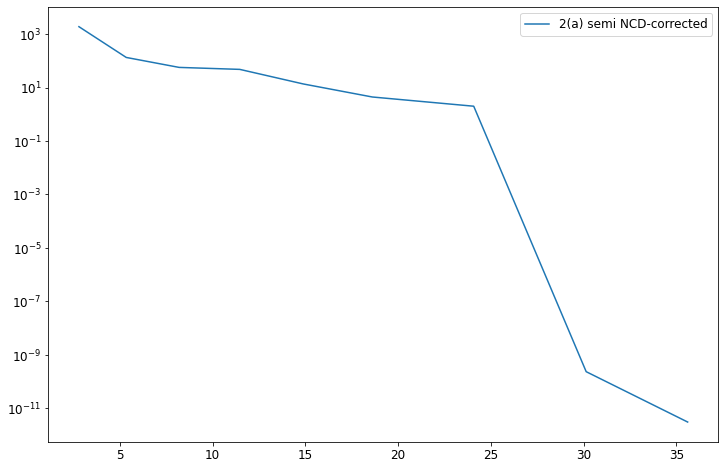

In [19]:
plt.semilogy(times_full_39_actual,J_error_39_actual, label='2(a) semi NCD-corrected')
plt.legend()

## TR BFGS - Single Basis - Variant 1(b)

In [20]:
import time
tic = time.time()
params = [mu]
opt_fom = opt_fom.with_(use_corrected_functional=False)
opt_fom = opt_fom.with_(use_corrected_gradient=False)
opt_fom = opt_fom.with_(adjoint_approach=False)


RBbasis, dual_RBbasis = build_initial_basis(opt_fom, params, build_sensitivities=False)

pdeopt_reductor = QuadraticPdeoptStationaryCoerciveReductor(opt_fom, 
                                                        RBbasis, dual_RBbasis, 
                                                        opt_product=opt_fom.opt_product,
                                                        coercivity_estimator=ce,
                                                        unique_basis=True,
                                                        mu_bar=mu_bar,
                                                        true_lagrange=False)

opt_rom = pdeopt_reductor.reduce()

tictoc = time.time() - tic


TR_parameters = {'beta': beta,
                 'safety_tolerance': safety_tol,
                 'radius': radius, 'FOC_tolerance': FOC_tolerance, 
                 'sub_tolerance': sub_tolerance,
                 'max_iterations': max_it, 'max_iterations_subproblem': max_it_sub, 
                 'max_iterations_armijo': max_it_arm,
                 'initial_step_armijo': init_step_armijo, 
                 'armijo_alpha': armijo_alpha,
                 'epsilon_i': epsilon_i, 
                 'starting_parameter': mu}

extension_params = {"Enlarge_radius": True, 'timings': True}

mus_54, times_54, Js_54, FOC_54 = TR_algorithm(
    opt_rom, pdeopt_reductor, TR_parameters, extension_params)

times_full_54_actual, J_error_54_actual, mu_error_54_actual, FOC_54_actual = compute_errors(
    opt_fom, J_start, J_opt, mu, mu_opt_as_array, mus_54[1:], Js_54, times_54, tictoc, FOC_54)

Starting with only one basis with length 1
starting parameter {biot: 0.31443290532552476, k0: 5.2380093294844015, k1: 4.453612643567742, k2: 4.351199118159355, k3: 2.96650091816554, k4: 8.196789068750364}
Starting value of the cost: 1887.0276550243555
******************************* 

___ starting subproblem
Computing the approximate Cauchy point and then start the BFGS method
boundary criterium of the TR satisfied, so stopping the sub-problem solver
checked sufficient condition, starting the enrichment
Length of Basis is 2
k: 0 - j 6 - Cost Functional: 139.0679451425605 - mu: {biot: 0.09498974371521753, k0: 0.7915133532735599, k1: 3.9222267508164856, k2: 4.195958045942626, k3: 1.4811220074241234, k4: 7.415558500172087}
computing the fom gradient since the model was enriched
First order critical condition: 2.2034578652949666
******************************* 

___ starting subproblem
Computing the approximate Cauchy point and then start the BFGS method
Curvature condition: -0.17180529318

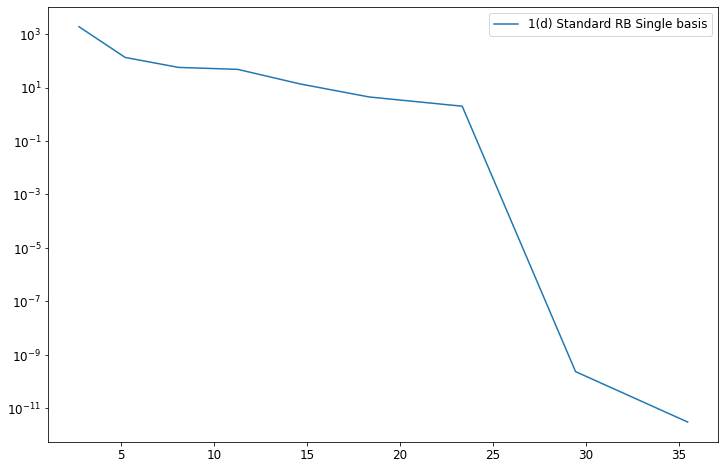

In [21]:
plt.semilogy(times_full_54_actual,J_error_54_actual, label='1(d) Standard RB Single basis')
plt.legend()

# Results

{biot: 0.01, k0: 0.1, k1: 8.37317446377103, k2: 6.572276066240383, k3: 0.46651735398635275, k4: 1.8835410659596712}


<pymor.discretizers.builtin.gui.jupyter.patch.visualize_patch.<locals>.Plot at 0x7f28e5a5de10>

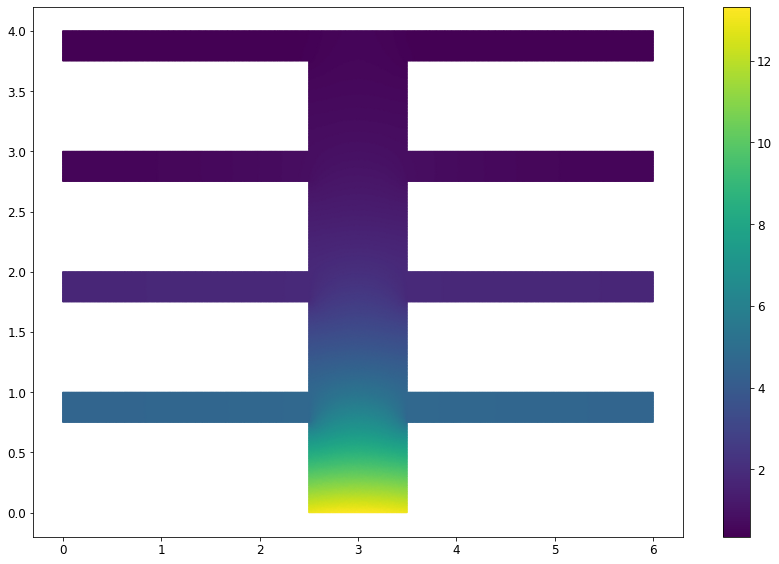

In [22]:
print(mu_opt)
u = opt_fom.solve(mu_opt)
opt_fom.visualize(u)

In [23]:
u = opt_fom.solve(mu_opt)
from pymor.discretizers.builtin.cg import (L2ProductP1, L2ProductQ1, InterpolationOperator)
from pymor.discretizers.builtin.grids.referenceelements import square
from pymor.discretizers.builtin.grids.boundaryinfos import EmptyBoundaryInfo
if data['grid'].reference_element is square:
    L2_OP = L2ProductQ1
else:
    L2_OP = L2ProductP1
if mu_d is None:
    empty_bi = EmptyBoundaryInfo(data['grid'])
    u_d = InterpolationOperator(data['grid'], ConstantFunction(u_d,2)).as_vector()
    diff= u.to_numpy()-u_d.to_numpy()
    diff_= opt_fom.solution_space.from_numpy(diff)
    Restricted_L2_OP = L2_OP(data['grid'], empty_bi, dirichlet_clear_rows=False, coefficient_function=domain_of_interest)
    print("{}".format(Restricted_L2_OP.apply2(diff_,diff_)[0][0]))
    print("{}".format(Restricted_L2_OP.apply2(diff_,diff_)[0][0]/Restricted_L2_OP.apply2(u_d,u_d)))

## Plot results

### J error

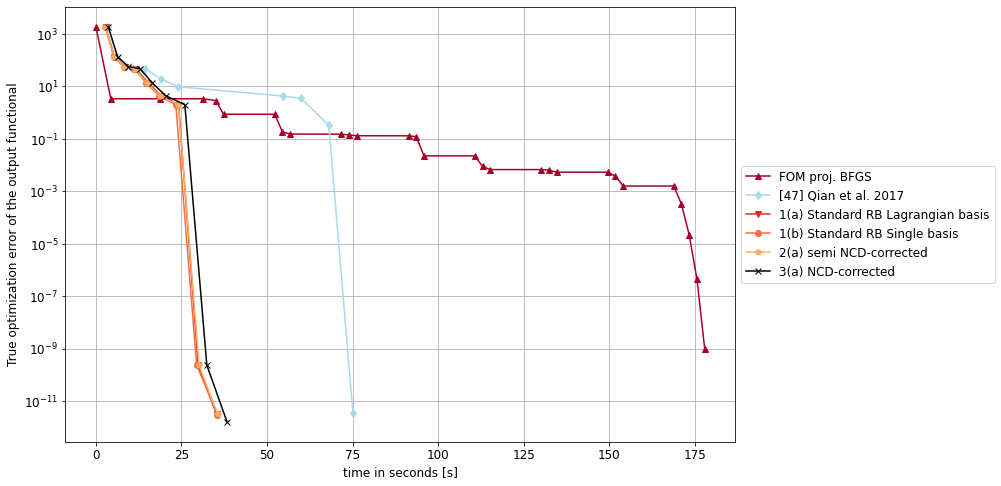

In [24]:
timings_figure = plt.figure()

color0 = (0.65,0,0.15)
color1 = (0.84,0.19,0.15)
color2 = (0.96,0.43,0.26)
color3 = (0.99,0.68,0.38)
color5 = (0.67,0.85,0.91)

#FOM
plt.semilogy(times_full_2,J_error_2,'^-', color=color0, label='FOM proj. BFGS')

# Qian et al. 2017
plt.semilogy(times_full_26_actual,J_error_26_actual,'d-', color=color5, label='[47] Qian et al. 2017')

# Lagrange Basis
plt.semilogy(times_full_25_actual,J_error_25_actual,'v-', color=color1, label='1(a) Standard RB Lagrangian basis')

# Unique Basis
plt.semilogy(times_full_54_actual,J_error_54_actual,'o-', color=color2, label='1(b) Standard RB Single basis')    

# Lagrange Basis
plt.semilogy(times_full_39_actual,J_error_39_actual,'p-', color=color3, label='2(a) semi NCD-corrected')
plt.semilogy(times_full_23_actual,J_error_23_actual,'x-k', label='3(a) NCD-corrected')


plt.xlabel('time in seconds [s]')
plt.ylabel('True optimization error of the output functional')
plt.grid()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

### Plot FOC

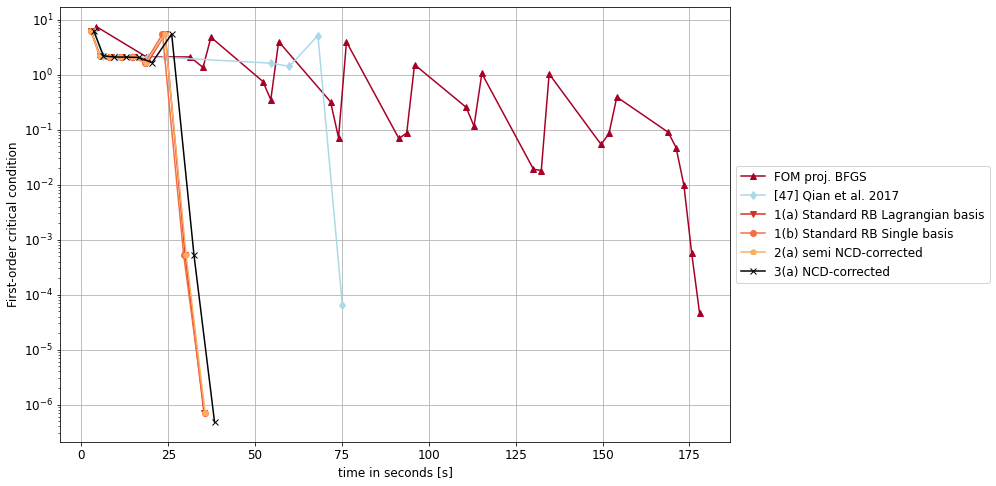

In [25]:
timings_figure = plt.figure()

#FOM
plt.semilogy(times_full_2[1:],FOC_2,'^-', color=color0, label='FOM proj. BFGS')

# Qian et al. 2017
plt.semilogy(times_full_26_actual,FOC_26_actual,'d-', color=color5, label='[47] Qian et al. 2017')

# Lagrange Basis
plt.semilogy(times_full_25_actual,FOC_25_actual,'v-', color=color1, label='1(a) Standard RB Lagrangian basis')

# Unique Basis
plt.semilogy(times_full_54_actual,FOC_54_actual,'o-', color=color2, label='1(b) Standard RB Single basis')    

# Lagrange Basis
plt.semilogy(times_full_39_actual,FOC_39_actual,'p-', color=color3, label='2(a) semi NCD-corrected')
plt.semilogy(times_full_23_actual,FOC_23_actual,'x-k', label='3(a) NCD-corrected')


plt.xlabel('time in seconds [s]')
plt.ylabel('First-order critical condition')
plt.grid()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

### Plot Mu error

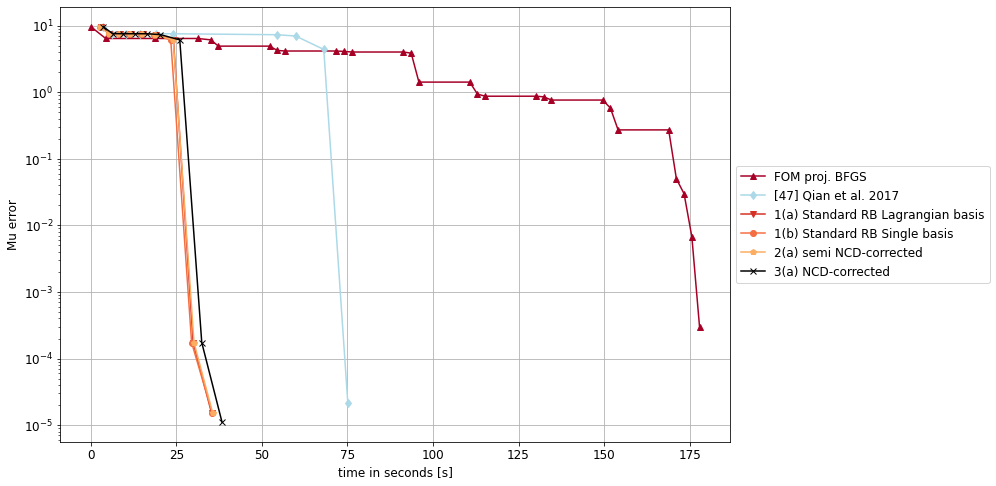

In [26]:
if mu_opt is not None:
    timings_figure = plt.figure()
    
    #FOM
    plt.semilogy(times_full_2,mu_error_2,'^-', color=color0, label='FOM proj. BFGS')

    # Qian et al. 2017
    plt.semilogy(times_full_26_actual,mu_error_26_actual,'d-', color=color5, label='[47] Qian et al. 2017')

    # Lagrange Basis
    plt.semilogy(times_full_25_actual,mu_error_25_actual,'v-', color=color1, label='1(a) Standard RB Lagrangian basis')

    # Unique Basis
    plt.semilogy(times_full_54_actual,mu_error_54_actual,'o-', color=color2, label='1(b) Standard RB Single basis')    

    # Lagrange Basis
    plt.semilogy(times_full_39_actual,mu_error_39_actual,'p-', color=color3, label='2(a) semi NCD-corrected')
    plt.semilogy(times_full_23_actual,mu_error_23_actual,'x-k', label='3(a) NCD-corrected')

    plt.xlabel('time in seconds [s]')
    plt.ylabel('Mu error')
    plt.grid()
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Save the data

In [27]:
#save data
from pdeopt.tools import save_data
directory = './results/Starter758'
save_data(directory, times_full_2, J_error_2, 2, mu_error=mu_error_2, FOC=FOC_2)
save_data(directory, times_full_23_actual, J_error_23_actual, 23, mu_error=mu_error_23_actual, FOC=FOC_23_actual)
save_data(directory, times_full_25_actual, J_error_25_actual, 25, mu_error=mu_error_25_actual, FOC=FOC_25_actual)
save_data(directory, times_full_26_actual, J_error_26_actual, 26, mu_error=mu_error_26_actual, FOC=FOC_26_actual)
save_data(directory, times_full_39_actual, J_error_39_actual, 39, mu_error=mu_error_39_actual, FOC=FOC_39_actual)
save_data(directory, times_full_54_actual, J_error_54_actual, 54, mu_error=mu_error_54_actual, FOC=FOC_54_actual)